<a href="https://colab.research.google.com/github/AleksandraBelousova/-Condition-prediction-based-on-fertility-data/blob/main/Fertility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhamedyoussry/fertility-data-set")

print("Path to dataset files:", path)

100%|██████████| 1.08k/1.08k [00:00<00:00, 2.18MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/muhamedyoussry/fertility-data-set/versions/1


Cross-validation: medium accuracy = 0.95
              precision    recall  f1-score   support

       False       0.75      0.60      0.67         5
        True       0.87      0.93      0.90        14

    accuracy                           0.84        19
   macro avg       0.81      0.76      0.78        19
weighted avg       0.84      0.84      0.84        19



<ipython-input-32-c3a53bbe6458>:64: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(pad=3)


<Figure size 1600x1200 with 0 Axes>

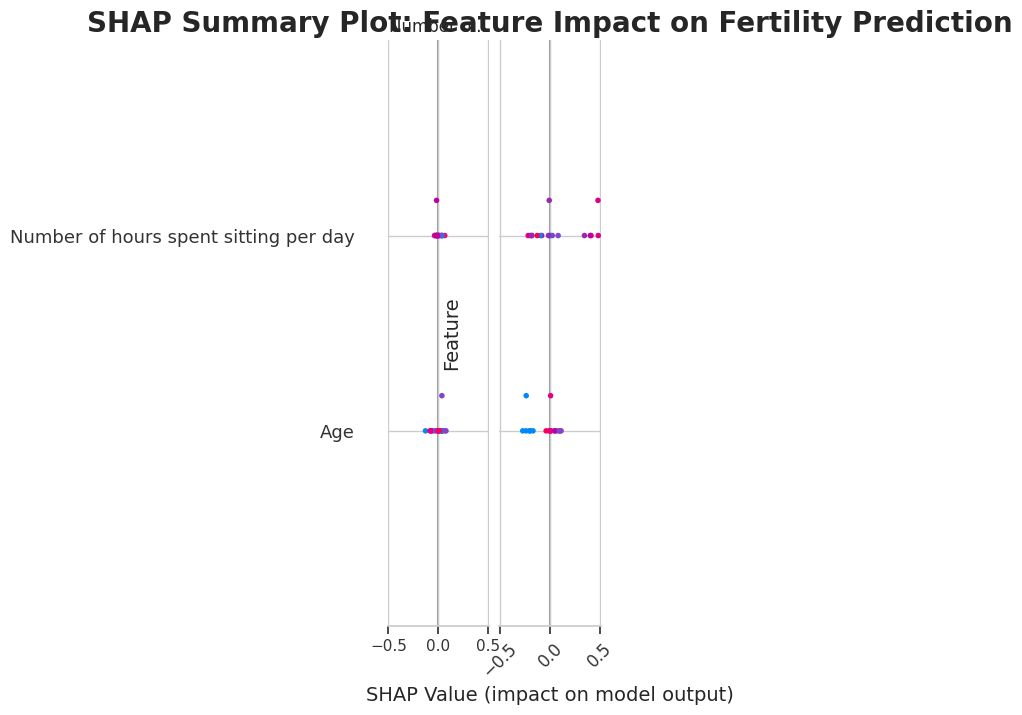

In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np

data = pd.read_csv('fertility.csv')
numeric_data = data.select_dtypes(include=[np.number])
categorical_data = data.select_dtypes(exclude=[np.number])
numeric_data.fillna(numeric_data.median(), inplace=True)
categorical_data.fillna(categorical_data.mode().iloc[0], inplace=True)

data = pd.concat([numeric_data, categorical_data], axis=1)
data_encoded = pd.get_dummies(data, drop_first=True)

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR)))]

for column in numeric_data.columns:
    data_encoded = remove_outliers(data_encoded, column)

X = data_encoded.drop('Diagnosis_Normal', axis=1)
y = data_encoded['Diagnosis_Normal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train_balanced, y_train_balanced)

cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5)
print(f"Cross-validation: medium accuracy = {cv_scores.mean()}")

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

sns.set(style="whitegrid", context="notebook")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list) and len(shap_values) > 1:
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

plt.figure(figsize=(16, 12))
shap.summary_plot(shap_values_to_plot, X_test, plot_type="dot", show=False, color=plt.get_cmap("viridis"))

plt.title('SHAP Summary Plot: Feature Impact on Fertility Prediction', fontsize=20, fontweight='bold')
plt.xlabel('SHAP Value (impact on model output)', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout(pad=3)
plt.savefig('shap_summary_high_res.png', dpi=300, bbox_inches='tight')
plt.show()

#This SHAP (SHapley Additive exPlanations) plot shows the effect of two characteristics on fertility prediction, 'number of hours sitting per day' and 'age'.
# Description:
# - On the x-axis is a SHAP value that shows how much each trait affects the model output.
# - Each point represents a prediction.
# - The colour of the points indicates the value of the trait: blue for smaller values, pink for larger values.

# Conclusions:
# - 'Number of hours sitting per day' has a noticeable positive contribution to the prediction when its value is high, which may indicate a negative effect on fertility.
# - Age' has a small direct effect on fertility prediction, with higher age generally having a small positive effect on prediction.

#Thus, it can be hypothesised that more hours of sedentary time and older age may be associated with changes in fertility model predictions.

In [30]:
data.head()
data.isnull().sum()

,0
Age,0
Number of hours spent sitting per day,0
Season,0
Childish diseases,0
Accident or serious trauma,0
Surgical intervention,0
High fevers in the last year,0
Frequency of alcohol consumption,0
Smoking habit,0
Diagnosis,0


In [5]:
numeric_data.fillna(numeric_data.median(), inplace=True)
categorical_data.fillna(categorical_data.mode().iloc[0], inplace=True)
data = pd.concat([numeric_data, categorical_data], axis=1)
data_encoded = pd.get_dummies(data, drop_first=True)

In [6]:
def remove_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for column in numeric_data.columns:
  data_encoded = remove_outliers(data_encoded, column)

In [7]:
X = data_encoded.drop('Diagnosis_Normal', axis=1)
y = data_encoded['Diagnosis_Normal']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [10]:
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [11]:
cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5)
print(f"Cross-validation: medium accuracy = {cv_scores.mean():.2f}")

Cross-validation: medium accuracy = 0.95


In [12]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

       False       0.75      0.60      0.67         5
        True       0.87      0.93      0.90        14

    accuracy                           0.84        19
   macro avg       0.81      0.76      0.78        19
weighted avg       0.84      0.84      0.84        19



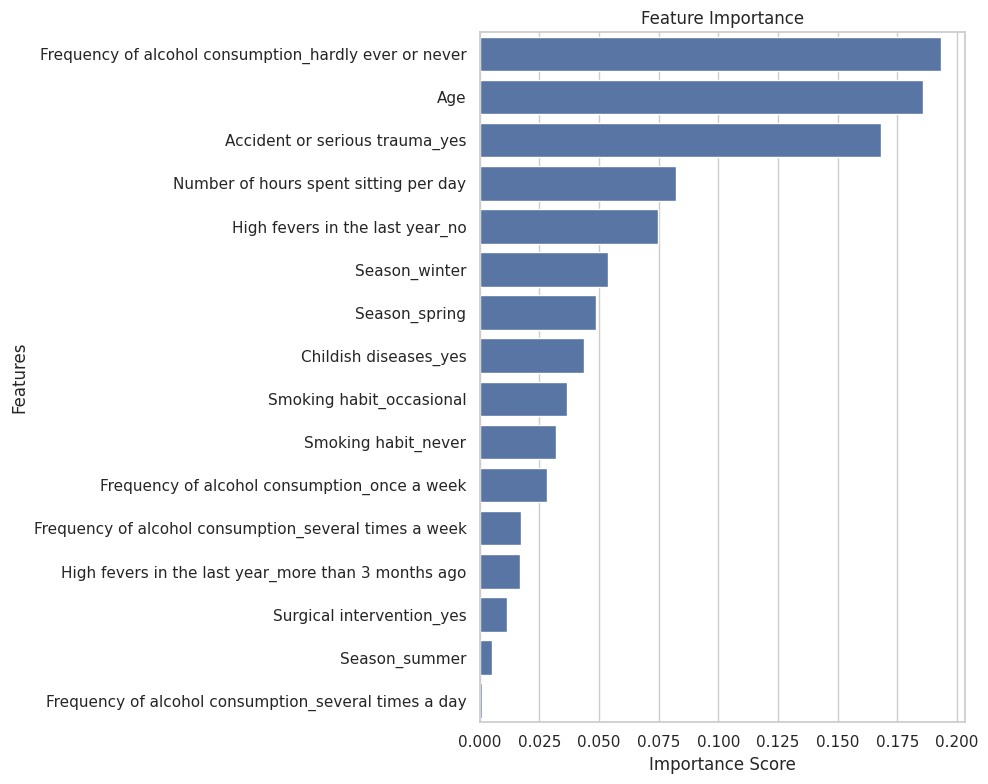

In [31]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
#Description:
# 1. Frequency of alcohol consumption (almost never or never) is most important.
# 2. Age is the second most important factor.
# 3. the presence of a serious injury or accident and the number of hours of sedentary time per day are also important.
# 4. Factors such as high temperatures in the last year and season (winter, spring) also play a role.
# Conclusion:
# Frequency of alcohol consumption and age are key factors in this model.